<a href="https://colab.research.google.com/github/yukiao/Pengantar-Deep-Learning/blob/main/Week5/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Silverius Sony Lembang  
NIM: H071191002

In [ ]:
!pip install d2l

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def conv_block(input_channels, num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels), nn.ReLU(),
      nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
  )

In [ ]:
class DenseBlock(nn.Module):
  def __init__(self, num_convs, input_channels, num_channels):
    super(DenseBlock, self).__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(
          num_channels * i + input_channels, num_channels
      ))
    self.net = nn.Sequential(*layer)
  
  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X,Y), dim=1)
    return X

In [ ]:
def transition_block(input_channels, num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels),
      nn.ReLU(),
      nn.Conv2d(input_channels, num_channels, kernel_size=1),
      nn.AvgPool2d(kernel_size=2, stride=2)
  )

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
  blks.append(DenseBlock(num_convs, num_channels, growth_rate))
  num_channels += num_convs * growth_rate

  if i != len(num_convs_in_dense_blocks) - 1 :
    blks.append(transition_block(num_channels, num_channels // 2))
    num_channels = num_channels // 2

In [ ]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

loss 0.142, train acc 0.949, test acc 0.792
778.5 examples/sec on cuda:0


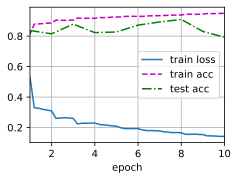

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())